In [1]:
# =========================
# Cell 1: Imports & setup
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Using device: cuda


In [2]:
# =========================
# Cell 2: Data loaders
# =========================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


100%|██████████| 26.4M/26.4M [00:01<00:00, 15.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.0MB/s]

Train size: 60000
Test size: 10000


In [3]:
# =========================
# Cell 3: Model definition
# =========================

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input: 1x28x28
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 16x28x28
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # 32x28x28
        self.pool = nn.MaxPool2d(2, 2)                           # 32x14x14 after pool
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # 16x28x28
        x = self.pool(F.relu(self.conv2(x)))  # 32x14x14
        x = x.view(x.size(0), -1)      # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_temp = SimpleCNN()
print("Number of trainable parameters:", count_params(model_temp))


Number of trainable parameters: 809034


In [4]:
# =========================
# Cell 4: Train & eval loops
# =========================

def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return total_loss / total, correct / total

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return total_loss / total, correct / total


In [5]:
# =========================
# Cell 5: Train two models
# =========================

def train_model(seed, epochs=5, lr=0.01):
    set_seed(seed)
    model = SimpleCNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, device)
        te_loss, te_acc = evaluate(model, test_loader, device)

        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        test_losses.append(te_loss)
        test_accs.append(te_acc)

        print(f"[Seed {seed}] Epoch {epoch+1}/{epochs} | "
              f"Train loss: {tr_loss:.4f}, acc: {tr_acc:.4f} | "
              f"Test loss: {te_loss:.4f}, acc: {te_acc:.4f}")

    return model, (train_losses, train_accs, test_losses, test_accs)

EPOCHS = 6  # small but enough to get decent accuracy

model_A, stats_A = train_model(seed=1, epochs=EPOCHS, lr=0.01)
model_B, stats_B = train_model(seed=2, epochs=EPOCHS, lr=0.01)


[Seed 1] Epoch 1/6 | Train loss: 0.6449, acc: 0.7726 | Test loss: 0.3960, acc: 0.8589
[Seed 1] Epoch 2/6 | Train loss: 0.3440, acc: 0.8756 | Test loss: 0.3687, acc: 0.8683
[Seed 1] Epoch 3/6 | Train loss: 0.2917, acc: 0.8945 | Test loss: 0.2935, acc: 0.8953
[Seed 1] Epoch 4/6 | Train loss: 0.2531, acc: 0.9086 | Test loss: 0.2744, acc: 0.9016
[Seed 1] Epoch 5/6 | Train loss: 0.2341, acc: 0.9136 | Test loss: 0.2741, acc: 0.8976
[Seed 1] Epoch 6/6 | Train loss: 0.2085, acc: 0.9244 | Test loss: 0.2708, acc: 0.8996
[Seed 2] Epoch 1/6 | Train loss: 0.6226, acc: 0.7765 | Test loss: 0.3993, acc: 0.8535
[Seed 2] Epoch 2/6 | Train loss: 0.3468, acc: 0.8743 | Test loss: 0.3344, acc: 0.8789
[Seed 2] Epoch 3/6 | Train loss: 0.2939, acc: 0.8933 | Test loss: 0.2991, acc: 0.8918
[Seed 2] Epoch 4/6 | Train loss: 0.2597, acc: 0.9057 | Test loss: 0.3022, acc: 0.8917
[Seed 2] Epoch 5/6 | Train loss: 0.2381, acc: 0.9131 | Test loss: 0.2681, acc: 0.9008
[Seed 2] Epoch 6/6 | Train loss: 0.2158, acc: 0.9207 |

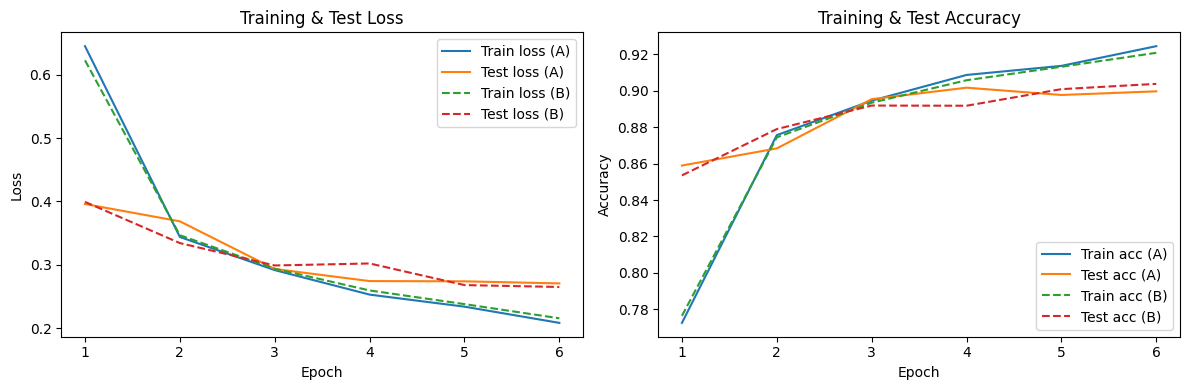

In [6]:
# =========================
# Cell 6: Basic training curves
# =========================

train_losses_A, train_accs_A, test_losses_A, test_accs_A = stats_A
train_losses_B, train_accs_B, test_losses_B, test_accs_B = stats_B

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses_A, label="Train loss (A)")
plt.plot(epochs_range, test_losses_A, label="Test loss (A)")
plt.plot(epochs_range, train_losses_B, "--", label="Train loss (B)")
plt.plot(epochs_range, test_losses_B, "--", label="Test loss (B)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs_A, label="Train acc (A)")
plt.plot(epochs_range, test_accs_A, label="Test acc (A)")
plt.plot(epochs_range, train_accs_B, "--", label="Train acc (B)")
plt.plot(epochs_range, test_accs_B, "--", label="Test acc (B)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
# =========================
# Cell 7: Flatten / unflatten utilities
# =========================

def get_flat_params(model):
    return torch.cat([p.detach().reshape(-1) for p in model.parameters()])

def get_flat_grads(model):
    return torch.cat([p.grad.detach().reshape(-1) for p in model.parameters()])

def set_flat_params(model, flat_vector):
    # Overwrite model parameters with values from flat_vector
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(flat_vector[offset:offset+numel].view_as(p))
        offset += numel

def get_param_shapes(model):
    return [p.shape for p in model.parameters()]


Hessian subset size: 2048
Power iteration 1/15, approx lambda_max: 12.6435
Power iteration 2/15, approx lambda_max: 18.7936
Power iteration 3/15, approx lambda_max: 23.7278
Power iteration 4/15, approx lambda_max: 23.0765
Power iteration 5/15, approx lambda_max: 17.3941
Power iteration 6/15, approx lambda_max: 20.4655
Power iteration 7/15, approx lambda_max: 20.5467
Power iteration 8/15, approx lambda_max: 16.5863
Power iteration 9/15, approx lambda_max: 21.1269
Power iteration 10/15, approx lambda_max: 17.3280
Power iteration 11/15, approx lambda_max: 17.0975
Power iteration 12/15, approx lambda_max: 16.8789
Power iteration 13/15, approx lambda_max: 19.9282
Power iteration 14/15, approx lambda_max: 15.8762
Power iteration 15/15, approx lambda_max: 12.9086
Power iteration 1/15, approx lambda_max: 7.5001
Power iteration 2/15, approx lambda_max: 12.2631
Power iteration 3/15, approx lambda_max: 14.1453
Power iteration 4/15, approx lambda_max: 12.1321
Power iteration 5/15, approx lambda_ma

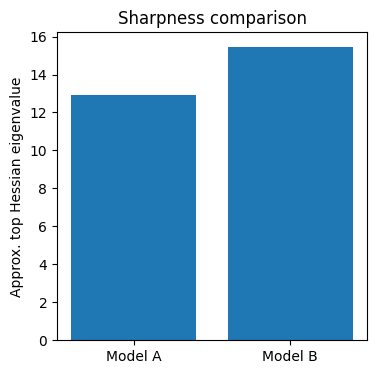

In [8]:
# =========================
# Cell 8: Hessian-vector product & top eigenvalue
# =========================

# Take a small subset for Hessian estimation (for speed)
subset_indices = list(range(0, 2048))  # first 2048 examples
hessian_subset = Subset(train_dataset, subset_indices)
hessian_loader = DataLoader(hessian_subset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
print("Hessian subset size:", len(hessian_subset))

def hessian_vector_product(model, data_loader, v, device):
    """
    Compute approximate (H @ v) where H is the Hessian of the loss w.r.t parameters.
    We use one batch (or a few) from data_loader for the estimate.
    """
    model.zero_grad()
    model.train()

    # Use a single batch for HVP
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(inputs)
    loss = F.cross_entropy(outputs, targets)

    grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    flat_grad = torch.cat([g.reshape(-1) for g in grads])

    # Compute (∇L · v)
    grad_v = (flat_grad * v).sum()
    # Now take gradient of grad_v to get H @ v
    Hv = torch.autograd.grad(grad_v, model.parameters(), retain_graph=False)
    flat_Hv = torch.cat([h.reshape(-1) for h in Hv]).detach()

    return flat_Hv

def power_iteration_top_eigenvalue(model, data_loader, device, iters=20):
    model.eval()
    flat_params = get_flat_params(model)
    dim = flat_params.numel()

    v = torch.randn(dim, device=device)
    v = v / v.norm()

    eigenvalue = None

    for i in range(iters):
        Hv = hessian_vector_product(model, data_loader, v, device)
        Hv_norm = Hv.norm()
        if Hv_norm.item() == 0:
            print("Zero Hv encountered.")
            break
        v = Hv / Hv_norm
        eigenvalue = torch.dot(v, hessian_vector_product(model, data_loader, v, device)).item()
        print(f"Power iteration {i+1}/{iters}, approx lambda_max: {eigenvalue:.4f}")

    return eigenvalue

lambda_max_A = power_iteration_top_eigenvalue(model_A, hessian_loader, device, iters=15)
lambda_max_B = power_iteration_top_eigenvalue(model_B, hessian_loader, device, iters=15)

print("Approx top Hessian eigenvalue (model A):", lambda_max_A)
print("Approx top Hessian eigenvalue (model B):", lambda_max_B)

# Simple bar plot comparing sharpness
plt.figure(figsize=(4,4))
plt.bar(["Model A", "Model B"], [lambda_max_A, lambda_max_B])
plt.ylabel("Approx. top Hessian eigenvalue")
plt.title("Sharpness comparison")
plt.show()


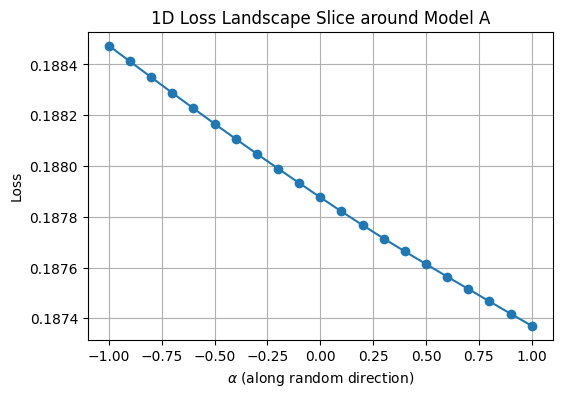

In [9]:
# =========================
# Cell 9: 1D loss landscape slice (model A)
# =========================

def evaluate_loss_on_loader(model, data_loader, device, max_batches=None):
    model.eval()
    total_loss = 0.0
    total = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)
            if max_batches is not None and i+1 >= max_batches:
                break
    return total_loss / total

# Use a smaller loader for speed
slice_loader = DataLoader(hessian_subset, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

theta_star = get_flat_params(model_A).to(device)
dim = theta_star.numel()

# Random direction v, normalized
v = torch.randn(dim, device=device)
v = v / v.norm()

# Scale for visualization: move within ±alpha_max in parameter space
alpha_values = np.linspace(-1.0, 1.0, 21)  # 21 points
scale = 0.05 * theta_star.norm().item()  # step size relative to parameter norm

losses_1d = []

model_clone = SimpleCNN().to(device)

for alpha in alpha_values:
    new_theta = theta_star + float(alpha) * scale * v
    set_flat_params(model_clone, new_theta)
    loss_val = evaluate_loss_on_loader(model_clone, slice_loader, device, max_batches=5)
    losses_1d.append(loss_val)

plt.figure(figsize=(6,4))
plt.plot(alpha_values, losses_1d, marker="o")
plt.xlabel(r"$\alpha$ (along random direction)")
plt.ylabel("Loss")
plt.title("1D Loss Landscape Slice around Model A")
plt.grid(True)
plt.show()


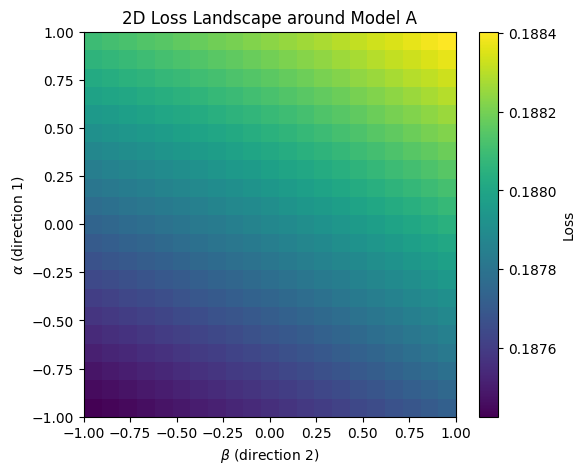

In [10]:
# =========================
# Cell 10: 2D loss landscape heatmap (model A)
# =========================

theta_star = get_flat_params(model_A).to(device)
dim = theta_star.numel()

# Two random directions, orthonormalized
v1 = torch.randn(dim, device=device)
v1 = v1 / v1.norm()

v2 = torch.randn(dim, device=device)
v2 = v2 - (v2 @ v1) * v1
v2 = v2 / v2.norm()

alpha_range = np.linspace(-1.0, 1.0, 21)
beta_range = np.linspace(-1.0, 1.0, 21)

scale2d = 0.03 * theta_star.norm().item()

loss_grid = np.zeros((len(alpha_range), len(beta_range)))

model_clone = SimpleCNN().to(device)

for i, alpha in enumerate(alpha_range):
    for j, beta in enumerate(beta_range):
        delta = scale2d * (float(alpha) * v1 + float(beta) * v2)
        new_theta = theta_star + delta
        set_flat_params(model_clone, new_theta)
        loss_val = evaluate_loss_on_loader(model_clone, slice_loader, device, max_batches=5)
        loss_grid[i, j] = loss_val

plt.figure(figsize=(6,5))
# imshow expects [rows, cols] => [alpha, beta]
extent = [beta_range[0], beta_range[-1], alpha_range[0], alpha_range[-1]]
plt.imshow(loss_grid, origin='lower', extent=extent, aspect='auto')
plt.colorbar(label="Loss")
plt.xlabel(r"$\beta$ (direction 2)")
plt.ylabel(r"$\alpha$ (direction 1)")
plt.title("2D Loss Landscape around Model A")
plt.show()


alpha=0.00 | train loss=0.1687, test loss=0.2423
alpha=0.05 | train loss=0.2304, test loss=0.2671
alpha=0.10 | train loss=0.3169, test loss=0.3427
alpha=0.15 | train loss=0.4930, test loss=0.5004
alpha=0.20 | train loss=0.7173, test loss=0.7157
alpha=0.25 | train loss=0.9416, test loss=0.9711
alpha=0.30 | train loss=1.2513, test loss=1.2401
alpha=0.35 | train loss=1.4813, test loss=1.4808
alpha=0.40 | train loss=1.6519, test loss=1.6712
alpha=0.45 | train loss=1.7913, test loss=1.7979
alpha=0.50 | train loss=1.8435, test loss=1.8464
alpha=0.55 | train loss=1.8067, test loss=1.8147
alpha=0.60 | train loss=1.6879, test loss=1.7047
alpha=0.65 | train loss=1.5152, test loss=1.5242
alpha=0.70 | train loss=1.2999, test loss=1.2882
alpha=0.75 | train loss=0.9693, test loss=0.9993
alpha=0.80 | train loss=0.7074, test loss=0.6929
alpha=0.85 | train loss=0.4720, test loss=0.4565
alpha=0.90 | train loss=0.2947, test loss=0.3205
alpha=0.95 | train loss=0.2094, test loss=0.2586
alpha=1.00 | train l

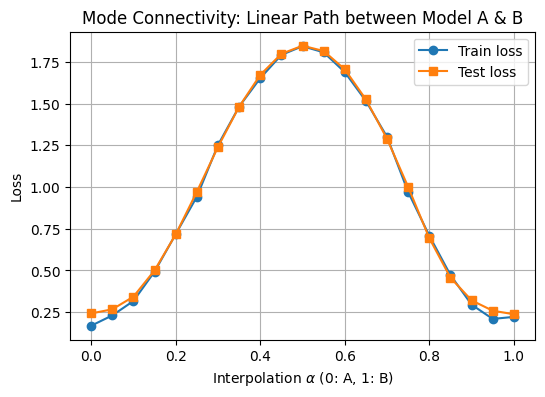

In [11]:
# =========================
# Cell 11: Mode connectivity (A → B)
# =========================

theta_A = get_flat_params(model_A).to(device)
theta_B = get_flat_params(model_B).to(device)

alphas_path = np.linspace(0.0, 1.0, 21)
train_losses_path = []
test_losses_path = []

model_path = SimpleCNN().to(device)

for alpha in alphas_path:
    theta_interp = (1.0 - float(alpha)) * theta_A + float(alpha) * theta_B
    set_flat_params(model_path, theta_interp)

    tr_loss = evaluate_loss_on_loader(model_path, train_loader, device, max_batches=5)
    te_loss = evaluate_loss_on_loader(model_path, test_loader, device, max_batches=5)
    train_losses_path.append(tr_loss)
    test_losses_path.append(te_loss)
    print(f"alpha={alpha:.2f} | train loss={tr_loss:.4f}, test loss={te_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(alphas_path, train_losses_path, marker="o", label="Train loss")
plt.plot(alphas_path, test_losses_path, marker="s", label="Test loss")
plt.xlabel(r"Interpolation $\alpha$ (0: A, 1: B)")
plt.ylabel("Loss")
plt.title("Mode Connectivity: Linear Path between Model A & B")
plt.legend()
plt.grid(True)
plt.show()


Noise std=0.000 | Test loss=0.2708, Test acc=0.8996
Noise std=0.010 | Test loss=0.2924, Test acc=0.8910
Noise std=0.020 | Test loss=0.2923, Test acc=0.8926
Noise std=0.050 | Test loss=0.5399, Test acc=0.8237
Noise std=0.100 | Test loss=5.1879, Test acc=0.3800


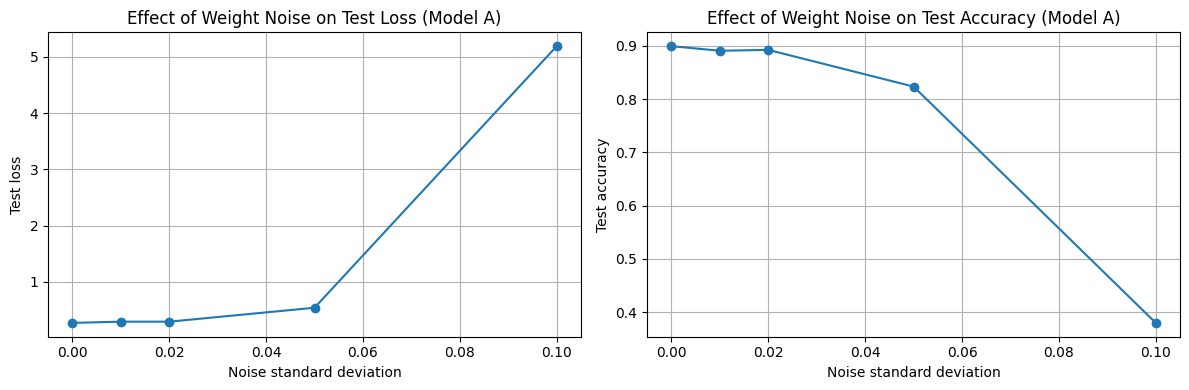

In [12]:
# =========================
# Cell 12: Robustness to weight perturbations (model A)
# =========================

theta_star = get_flat_params(model_A).to(device)
model_perturb = SimpleCNN().to(device)

noise_levels = [0.0, 0.01, 0.02, 0.05, 0.1]
test_losses_noise = []
test_accs_noise = []

def evaluate_full(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += inputs.size(0)
    return total_loss / total, correct / total

for sigma in noise_levels:
    if sigma == 0.0:
        noisy_theta = theta_star.clone()
    else:
        noise = sigma * torch.randn_like(theta_star)
        noisy_theta = theta_star + noise

    set_flat_params(model_perturb, noisy_theta)
    loss_val, acc_val = evaluate_full(model_perturb, test_loader, device)
    test_losses_noise.append(loss_val)
    test_accs_noise.append(acc_val)
    print(f"Noise std={sigma:.3f} | Test loss={loss_val:.4f}, Test acc={acc_val:.4f}")

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(noise_levels, test_losses_noise, marker="o")
plt.xlabel("Noise standard deviation")
plt.ylabel("Test loss")
plt.title("Effect of Weight Noise on Test Loss (Model A)")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(noise_levels, test_accs_noise, marker="o")
plt.xlabel("Noise standard deviation")
plt.ylabel("Test accuracy")
plt.title("Effect of Weight Noise on Test Accuracy (Model A)")
plt.grid(True)

plt.tight_layout()
plt.show()
